# Random Forests 

Random forests average many decision trees to reduce variance. Each tree is grown on a bootstrap sample of the training rows, and each split considers only a random subset of predictors of size $m_{\text{try}}$. two sources of randomness (rows and variables) decorrelate trees so that their average has lower variance than any single tree 

Out-of-bag (OOB) estimation, each tree leaves out about $1 - (1 - 1/n)^n \approx 36\%$ of rows. For each row, average predictions from trees that did not see it and compute an OOB error. This behaves like an internal cross-validation without a separate split

Variable importance
- MDI (Mean Decrease in Impurity): sum of impurity drops a predictor causes across the forest
- MDA (Permutation importance): increase in OOB error when the predictor’s values are permuted

Key hyperparameters
- $T$ (ntree): number of trees. Larger $T$ lowers variance until OOB error stabilizes  
- $m_{\text{try}}$: predictors considered at each split. Common defaults are $\sqrt{p}$ for classification, $p/3$ for regression.  
- nodesize / maxnodes: controls leaf size and depth; larger leaves reduce variance but may underfit.  
- sampsize / class weights: address class imbalance when needed.

**Strengths and caveats.** Robust to noisy features, minimal preprocessing, handles mixed numeric/factor data, and provides OOB error and importance

In [1]:
library(fairml)
 library(klaR)

Loading required package: MASS



In [2]:

library(randomForest)
library(mlbench)
library(pROC)


randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




In [3]:
data(GermanCredit)
dataset = GermanCredit

In [4]:
names(dataset)

[1] "status"                  "duration"               
 [3] "credit_history"          "purpose"                
 [5] "amount"                  "savings"                
 [7] "employment_duration"     "installment_rate"       
 [9] "personal_status_sex"     "other_debtors"          
[11] "present_residence"       "property"               
[13] "age"                     "other_installment_plans"
[15] "housing"                 "number_credits"         
[17] "job"                     "people_liable"          
[19] "telephone"               "foreign_worker"         
[21] "credit_risk"

In [5]:
dataset$credit_risk = factor(dataset$credit_risk)

In [7]:
n = nrow(dataset)
test_fraction = 0.30
test_index = sample(seq_len(n), size = floor(test_fraction * n))
training_set = dataset[-test_index, ]
testing_set  = dataset[test_index, ]


In [8]:
p = ncol(training_set) - 1
rf_credit = randomForest(
  credit_risk ~ .,
  data = training_set,
  ntree = 600,
  mtry = max(1, floor(sqrt(p))),
  importance = TRUE,
  keep.forest = TRUE
)



Call:
 randomForest(formula = credit_risk ~ ., data = training_set,      ntree = 600, mtry = max(1, floor(sqrt(p))), importance = TRUE,      keep.forest = TRUE) 
               Type of random forest: classification
                     Number of trees: 600
No. of variables tried at each split: 4

        OOB estimate of  error rate: 24.57%
Confusion matrix:
     good bad class.error
good  446  39  0.08041237
bad   133  82  0.61860465


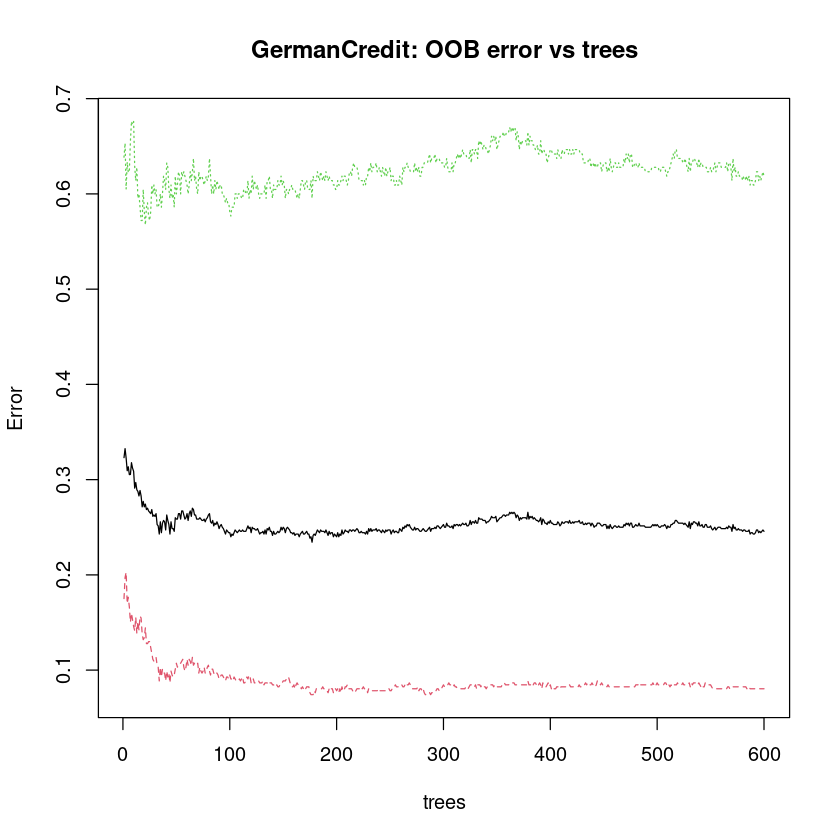

In [9]:
print(rf_credit)
plot(rf_credit, main = "GermanCredit: OOB error vs trees")

In [10]:
oob_confusion = rf_credit$confusion
if ("class.error" %in% colnames(oob_confusion)) {
  oob_counts = as.matrix(oob_confusion[ , setdiff(colnames(oob_confusion), "class.error"), drop = FALSE])
  oob_error = 1 - sum(diag(oob_counts)) / sum(oob_counts)
} else {
  oob_counts = as.matrix(oob_confusion)
  oob_error = 1 - sum(diag(oob_counts)) / sum(oob_counts)
}
oob_error

[1] 0.2457143

In [11]:
pred_train_class = predict(rf_credit, newdata = training_set, type = "class")
pred_test_class  = predict(rf_credit, newdata = testing_set,  type = "class")
train_error = mean(pred_train_class != training_set$credit_risk)
test_error  = mean(pred_test_class  != testing_set$credit_risk)


,good,bad,MeanDecreaseAccuracy,MeanDecreaseGini
status,18.873797,31.049284,31.990845,33.99146
duration,11.250823,5.852035,13.199229,25.42218
credit_history,16.454730,10.972410,19.003736,23.98670
purpose,2.440915,4.348710,4.524843,25.65406
amount,7.513705,5.910682,9.733147,36.12090
savings,3.391422,11.277792,10.017788,16.48384


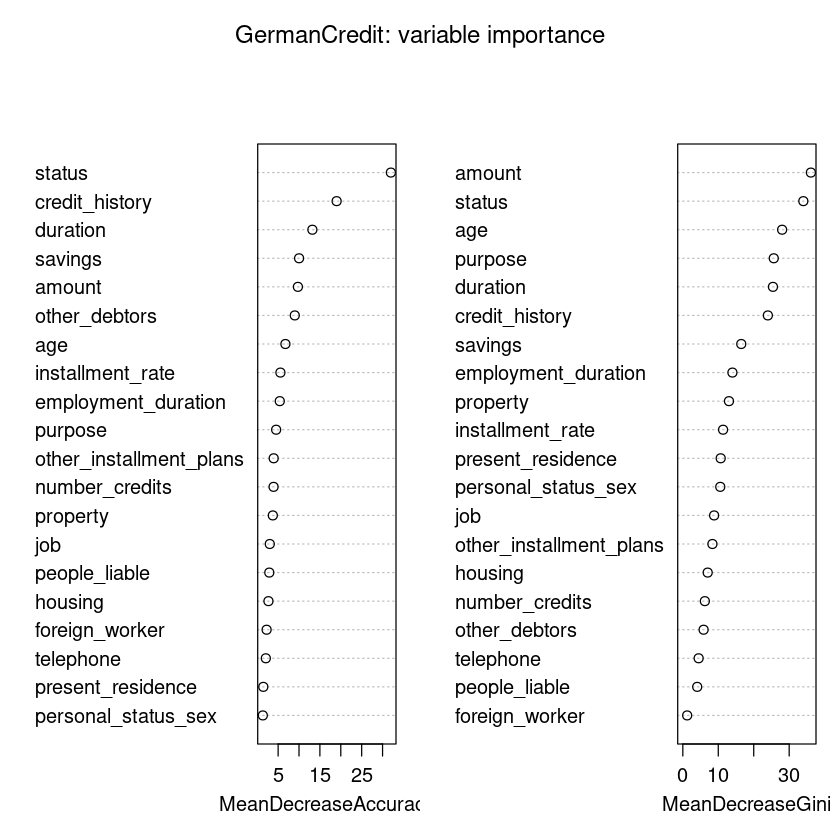

In [12]:
varImpPlot(rf_credit, main = "GermanCredit: variable importance")
importance_matrix = importance(rf_credit)
head(importance_matrix)

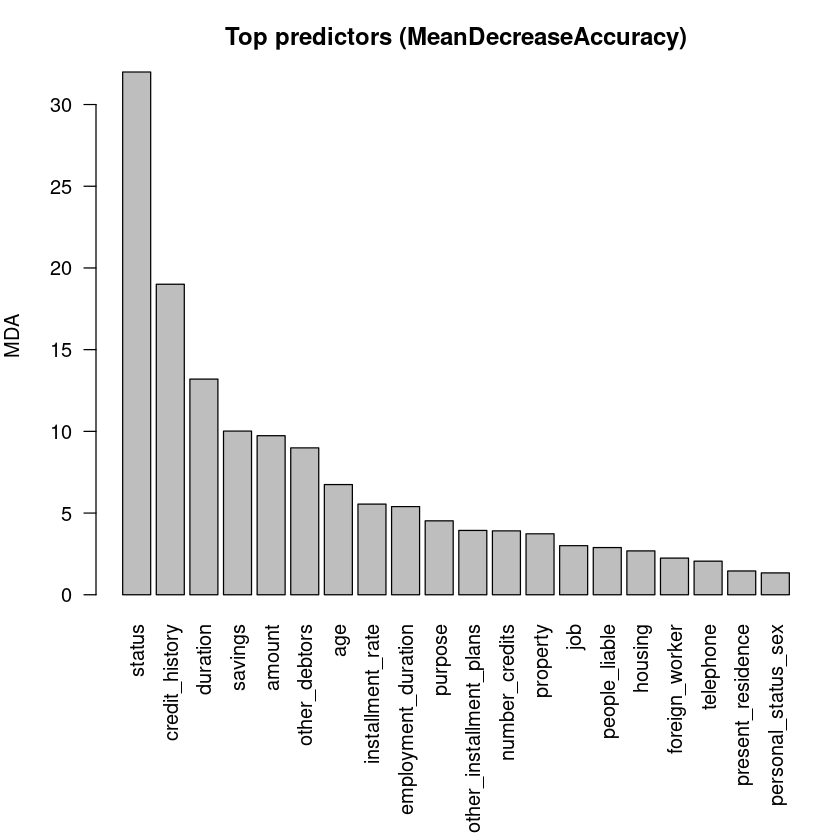

In [13]:
mda = importance_matrix[ , "MeanDecreaseAccuracy"]
mda = sort(mda, decreasing = TRUE)
top_k = min(20, length(mda))
par(mar = c(10, 4, 3, 1))
barplot(mda[1:top_k], las = 2, main = "Top predictors (MeanDecreaseAccuracy)", ylab = "MDA")


In [14]:
levels_target = levels(training_set$credit_risk)
if ("Bad" %in% levels_target) {
  pos_label = "Bad"
} else if ("bad" %in% levels_target) {
  pos_label = "bad"
} else {
  pos_label = levels_target[length(levels_target)]
}

In [24]:
pred_test_prob = predict(rf_credit, newdata = testing_set, type = "prob")[ , pos_label]
mean( as.numeric( (as.numeric(testing_set$credit_risk) - 1) == (pred_test_prob > 0.5) ) )

[1] 0.77

In [28]:
table(  (as.numeric(testing_set$credit_risk) - 1) , (pred_test_prob > 0.75) )

   
    FALSE TRUE
  0   215    0
  1    83    2

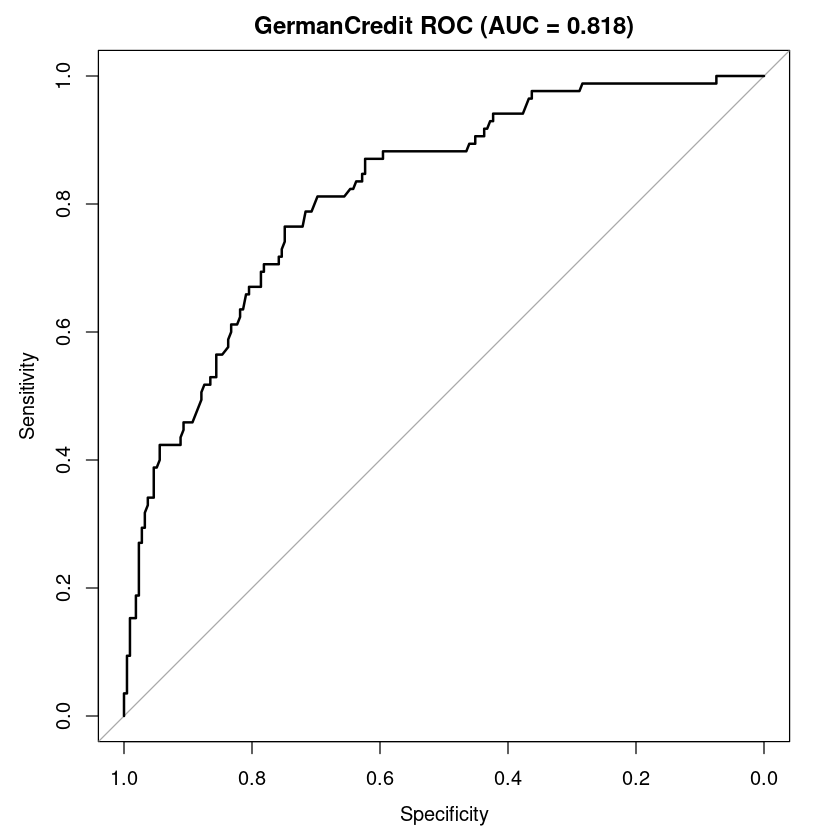

In [29]:

pred_test_prob = predict(rf_credit, newdata = testing_set, type = "prob")[ , pos_label]
roc_obj = roc(response = testing_set$credit_risk,
              predictor = pred_test_prob,
              levels = c(setdiff(levels_target, pos_label), pos_label),
              direction = "<")
auc_value = as.numeric(auc(roc_obj))
plot(roc_obj, main = paste0("GermanCredit ROC (AUC = ", round(auc_value, 3), ")"))


In [30]:
levels_target = levels(testing_set$credit_risk)
if ("Bad" %in% levels_target) {
  pos_label = "Bad"
} else if ("bad" %in% levels_target) {
  pos_label = "bad"
} else {
  pos_label = levels_target[length(levels_target)]
}
neg_label = setdiff(levels_target, pos_label)[1]

In [31]:
pred_test_prob = predict(rf_credit, newdata = testing_set, type = "prob")[ , pos_label]

In [38]:
threshold = 0.5
pred_label = ifelse(pred_test_prob >= threshold, pos_label, neg_label)
pred_label = factor(pred_label, levels = levels_target)


In [39]:

cm = table(Observed = testing_set$credit_risk, Predicted = pred_label)
cm

        Predicted
Observed good bad
    good  190  25
    bad    44  41

In [40]:

TP = cm[pos_label, pos_label]
TN = cm[neg_label, neg_label]
FP = cm[neg_label, pos_label]
FN = cm[pos_label, neg_label]


In [41]:

metrics = c(
  TPR_sensitivity = TP / (TP + FN),
  FPR = FP / (FP + TN),
  Specificity = TN / (TN + FP),
  Precision = TP / (TP + FP),
  Accuracy = (TP + TN) / sum(cm)
)
metrics

TPR_sensitivity             FPR     Specificity       Precision        Accuracy 
      0.4823529       0.1162791       0.8837209       0.6212121       0.7700000

In [42]:
threshold_grid = seq(0, 1, by = 0.01)

In [43]:

TP_vec = TN_vec = FP_vec = FN_vec = numeric(length(threshold_grid))
TPR_vec = FPR_vec = Precision_vec = Accuracy_vec = numeric(length(threshold_grid))


In [44]:

for (i in seq_along(threshold_grid)) {
  thr = threshold_grid[i]
  pred_i = ifelse(pred_test_prob >= thr, pos_label, neg_label)
  pred_i = factor(pred_i, levels = levels_target)
  cm_i = table(Observed = testing_set$credit_risk, Predicted = pred_i)

  TP_vec[i] = cm_i[pos_label, pos_label]
  TN_vec[i] = cm_i[neg_label, neg_label]
  FP_vec[i] = cm_i[neg_label, pos_label]
  FN_vec[i] = cm_i[pos_label, neg_label]

  TPR_vec[i] = ifelse((TP_vec[i] + FN_vec[i]) > 0, TP_vec[i] / (TP_vec[i] + FN_vec[i]), NA)
  FPR_vec[i] = ifelse((FP_vec[i] + TN_vec[i]) > 0, FP_vec[i] / (FP_vec[i] + TN_vec[i]), NA)
  Precision_vec[i] = ifelse((TP_vec[i] + FP_vec[i]) > 0, TP_vec[i] / (TP_vec[i] + FP_vec[i]), NA)
  Accuracy_vec[i] = (TP_vec[i] + TN_vec[i]) / sum(cm_i)
}


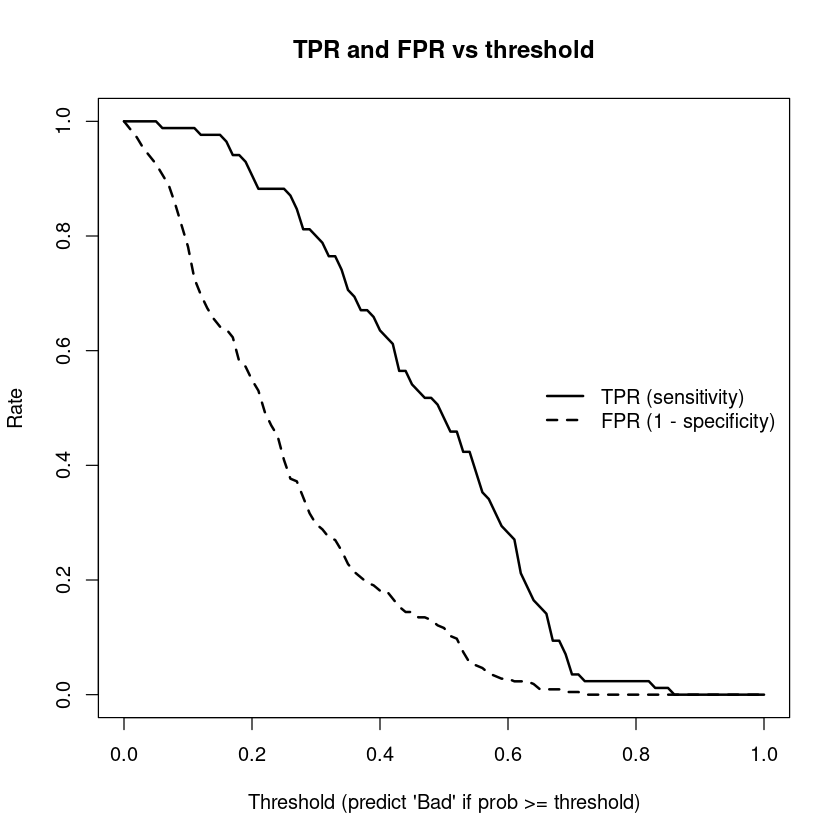

In [45]:
plot(threshold_grid, TPR_vec, type = "l", lwd = 2,
     xlab = "Threshold (predict 'Bad' if prob >= threshold)",
     ylab = "Rate",
     main = "TPR and FPR vs threshold")
lines(threshold_grid, FPR_vec, lwd = 2, lty = 2)
legend("right", legend = c("TPR (sensitivity)", "FPR (1 - specificity)"),
       lty = c(1, 2), lwd = 2, bty = "n")

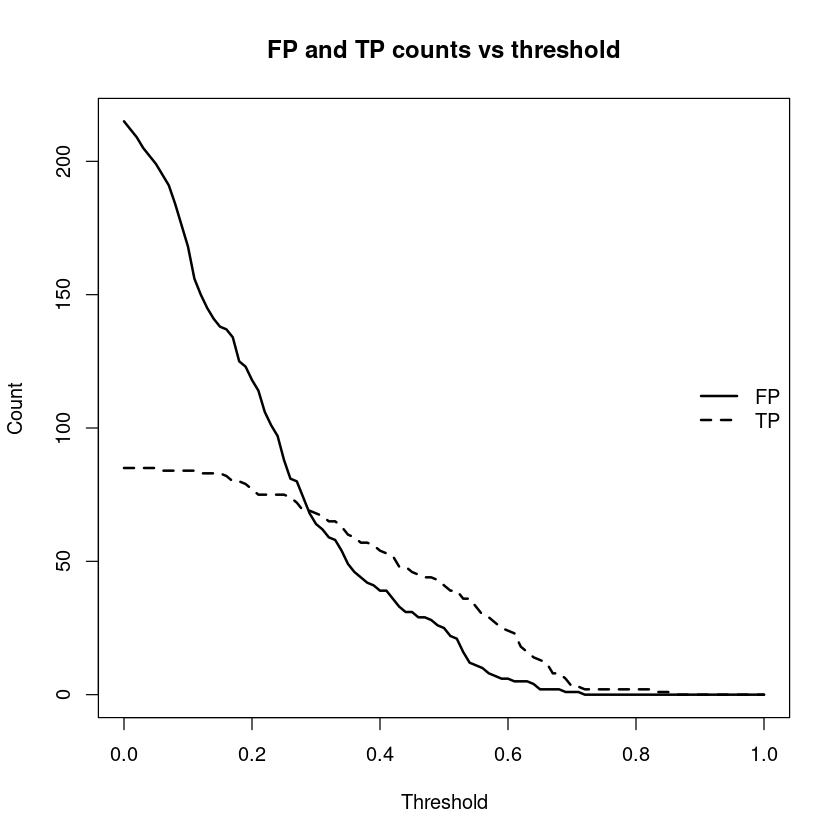

In [46]:
plot(threshold_grid, FP_vec, type = "l", lwd = 2,
     xlab = "Threshold", ylab = "Count",
     main = "FP and TP counts vs threshold")
lines(threshold_grid, TP_vec, lwd = 2, lty = 2)
legend("right", legend = c("FP", "TP"), lty = c(1, 2), lwd = 2, bty = "n")
